In [2]:
 #Import all packages needed to analyze data
import scipy, numpy, cv2
import matplotlib as mpl
import matplotlib.style as style
from matplotlib import pyplot as plt

In [44]:
PATH1 = '/mnt/c/Users/Devynn/Dropbox (Point Road Solutions)/PRS_Engineering/Madagascar2018/10-20/Bullfrog_camera/G0192070.JPG'
PATH2 = '/mnt/c/Users/Devynn/Dropbox (Point Road Solutions)/PRS_Engineering/Madagascar2018/10-20/Bullfrog_camera/Stripped Audio/GOPR2025_quiet.MP4'

img = cv2.imread(PATH1)
vid = cv2.VideoCapture(PATH2)

Text(0.5,1,'Video Stream Capture')

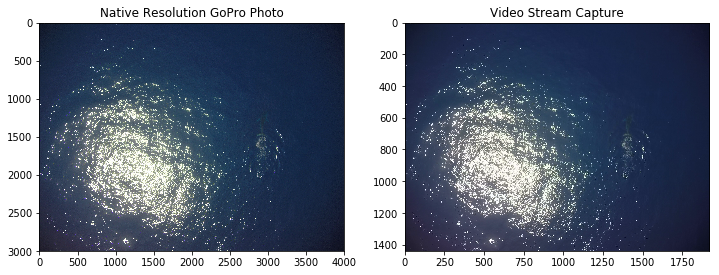

In [45]:
#Convert BGR to RBG
mpl.rcParams['figure.figsize'] = [12.0, 9.0]
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Capture correct video frame
vid = cv2.VideoCapture(PATH2)
frameflag = 5399
count = 0

while(True):
    rval, frame = cv2.VideoCapture.read(vid)
    if count == frameflag:
        break
    count +=1
vid.release()

#Plot Everything
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title('Native Resolution GoPro Photo')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title('Video Stream Capture')


Text(0.5,1,'Video Stream Capture')

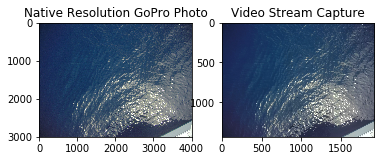

In [2]:
# Something about GoPro audio codec causes all videos to briefly return False for 20-80 frames, starting at the 16th frame
# Stripping audio from the .mp4 file using ffmpeg fixes the problem. Why was this ever a problem tho

PATH3 = '/mnt/c/Users/Devynn/Dropbox (Point Road Solutions)/PRS_Engineering/Madagascar2018/10-20/Bullfrog_camera/G0171996.JPG'
img2 = cv2.imread(PATH3)

PATH4 = '/mnt/c/Users/Devynn/Dropbox (Point Road Solutions)/PRS_Engineering/Madagascar2018/10-20/Bullfrog_camera/GOPR1968.MP4'
vid2 = cv2.VideoCapture(PATH4)

frameflag = 3357 + 26
count = 0

while(True):
    rval, frame = cv2.VideoCapture.read(vid2)
    if count == frameflag:
        break
    count +=1
vid2.release()

frame_colorcorrect = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.subplot(1, 2, 1)
plt.imshow(img2_rgb)
plt.title('Native Resolution GoPro Photo')
plt.subplot(1, 2, 2)
plt.imshow(frame_colorcorrect)
plt.title('Video Stream Capture')

<generator object <genexpr> at 0x7f9e6f519258>


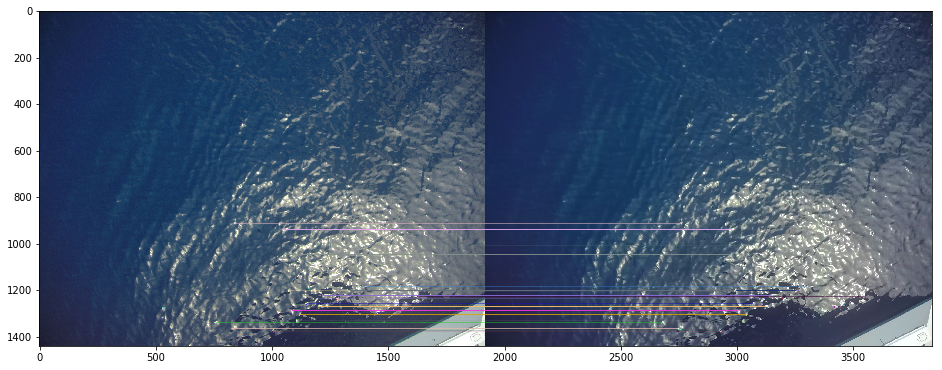

In [3]:
#Downsize img2_rgb to the same size as frame_colorcorrect
img2_resize = cv2.resize(img2_rgb, (1920, 1440))

#Brute-force matcher tests from docs.opencv.org. Uses img2_resize and frame_colorcorrect from above

orb = cv2.ORB_create()

kp1, des1 = orb.detectAndCompute(img2_resize, None)
kp2, des2 = orb.detectAndCompute(frame_colorcorrect, None)

# create BF Matcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match Descriptors
matches = bf.match(des1,des2)

# Sort them in the order of their distance
matches = sorted(matches, key = lambda x:x.distance)

print(m.distance for m in matches)

# Draw first 20 matches
imagematches = cv2.drawMatches(img2_resize, kp1, frame_colorcorrect, kp2, matches[:40], None, flags=2)
# Tutorial code excludes None in pos 6 but appears to be necessary after following a stackoverflow thread on the topic

mpl.rcParams['figure.figsize'] = [16.0, 12.0]
plt.imshow(imagematches)

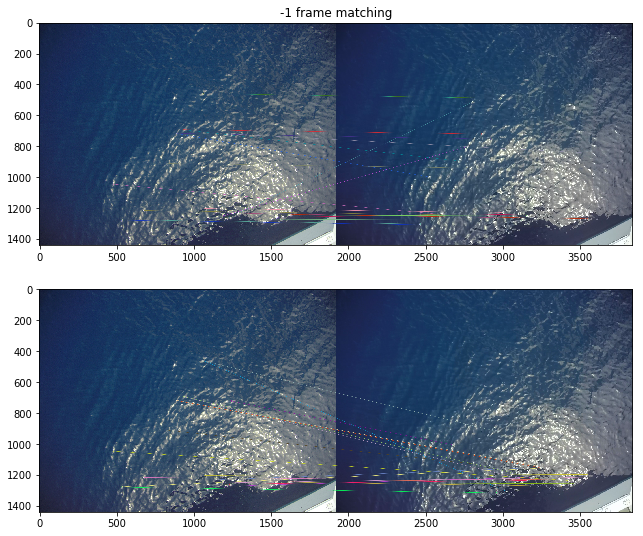

In [113]:
#Brute-force matcher tests, using -1 frame amd +1 frame

orb = cv2.ORB_create()
before_colcorr = cv2.cvtColor(beforeframe, cv2.COLOR_BGR2RGB)

kp3, des3 = orb.detectAndCompute(img2_resize, None)
kp4, des4 = orb.detectAndCompute(before_colcorr, None)

# create BF Matcher object
bf2 = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match Descriptors
matches2 = bf2.match(des3,des4)

# Sort them in the order of their distance
matches2_ordered = sorted(matches2, key = lambda x:x.distance)

# Draw first 20 matches
imagematches2 = cv2.drawMatches(img2_resize, kp3, before_colcorr, kp4, matches2_ordered[:20], None, flags=2)
# Tutorial code excludes None in pos 6 but appears to be necessary after following a stackoverflow thread on the topic

after_colcorr = cv2.cvtColor(afterframe, cv2.COLOR_BGR2RGB)

kp5, des5 = orb.detectAndCompute(img2_resize, None)
kp6, des6 = orb.detectAndCompute(after_colcorr, None)

# create BF Matcher object
bf3 = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match Descriptors
matches3 = bf3.match(des3,des4)

# Sort them in the order of their distance
matches3 = sorted(matches3, key = lambda x:x.distance)

# Draw first 20 matches
imagematches3 = cv2.drawMatches(img2_resize, kp5, after_colcorr, kp6, matches3[:20], None, flags=2)
# Tutorial code excludes None in pos 6 but appears to be necessary after following a stackoverflow thread on the topic

plt.subplot(2,1,1)
plt.imshow(imagematches2)
plt.title('-1 frame matching')
plt.subplot(2,1,2)
plt.imshow(imagematches3)
plt.title('+1 frame matching')
plt.show()

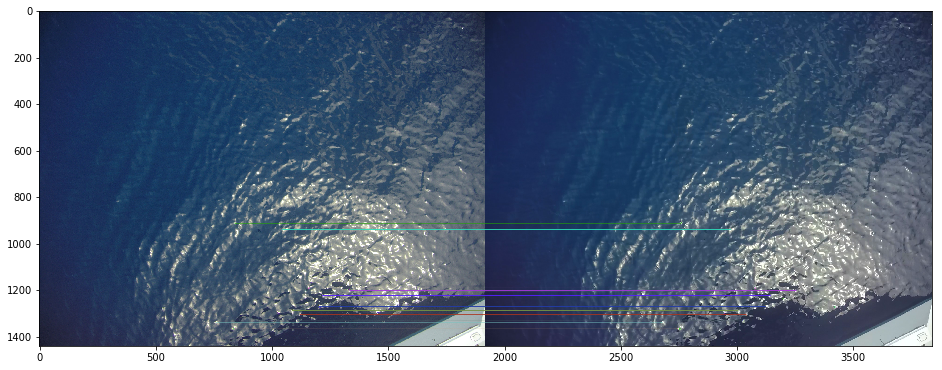

In [68]:
#This method can be used with other images and videos in the dropbox folders
#FRAME OFFSET IS DUE TO GOPRO AUDIO CODEC ISSUES: can be resolved by stripping audio stream using ffmpeg

PATH3 = '/mnt/c/Users/Devynn/Dropbox (Point Road Solutions)/PRS_Engineering/Madagascar2018/10-20/Bullfrog_camera/G0171996.JPG'
img2 = cv2.imread(PATH3)

PATH4 = '/mnt/c/Users/Devynn/Dropbox (Point Road Solutions)/PRS_Engineering/Madagascar2018/10-20/Bullfrog_camera/GOPR1968.MP4'
vid2 = cv2.VideoCapture(PATH4)

frameflag = 3357+26
count = 0
frameset = []
frameset_colorcorrect = []
framecheck = 5
kps = []
des = []
matches = []
matches_means = []

while(True):
    rval, frame = cv2.VideoCapture.read(vid2)
    if count in range(frameflag - framecheck, frameflag + framecheck):
        frameset.append(frame)
    if count == frameflag + framecheck:
        break
    count +=1
vid2.release()

img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

for i in range(len(frameset)):
    frameset_colorcorrect.append(cv2.cvtColor(frameset[i], cv2.COLOR_BGR2RGB))

#Downsize img2_rgb to the same size as frame_colorcorrect
img2_resize = cv2.resize(img2_rgb, (1920, 1440))

#Brute-force matcher tests from docs.opencv.org. Uses img2_resize and frame_colorcorrect from above

orb = cv2.ORB_create()

kp1, des1 = orb.detectAndCompute(img2_resize, None)

for i in range(len(frameset)):
    kp2, des2 = orb.detectAndCompute(frameset_colorcorrect[i], None)
    kps.append(kp2)
    des.append(des2)
    
# create BF Matcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match Descriptors
for i in range(len(des)):
    matches.append(bf.match(des1,des[i]))
    matches[-1] = sorted(matches[-1], key = lambda x:x.distance)
    matches_means.append(sum(m.distance for m in matches[-1])/len(matches[-1]))
    
framestop = matches_means.index(min(matches_means))
match_fstop = matches[framestop]
# Sort them in the order of their distance
#matches = sorted(matches, key = lambda x:x.distance)
#matches3 = matches[3]
#print(m.distance for m in matches)

# Draw first 20 matches
imagematches = cv2.drawMatches(img2_resize, kp1, frameset_colorcorrect[framestop], kps[framestop], match_fstop[:20], None, flags=2)
# Tutorial code excludes None in pos 6 but appears to be necessary after following a stackoverflow thread on the topic

#mpl.rcParams['figure.figsize'] = [16.0, 12.0]
plt.imshow(imagematches)

5446


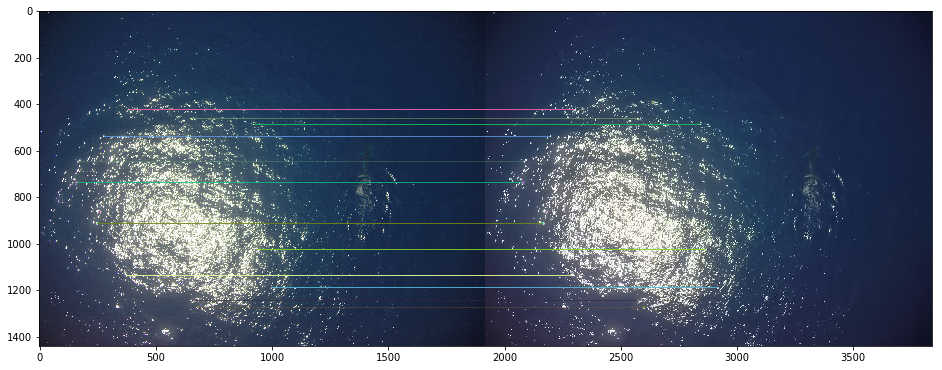

In [74]:
#Same code as above, different paths, different frame flags. Still seems to work fine

PATH3 = '/mnt/c/Users/Devynn/Dropbox (Point Road Solutions)/PRS_Engineering/Madagascar2018/10-20/Bullfrog_camera/G0192070.JPG'
img2 = cv2.imread(PATH3)

PATH4 = '/mnt/c/Users/Devynn/Dropbox (Point Road Solutions)/PRS_Engineering/Madagascar2018/10-20/Bullfrog_camera/GOPR2025.MP4'
vid2 = cv2.VideoCapture(PATH4)

frameflag = 5399+50
count = 0
frameset = []
frameset_colorcorrect = []
framecheck = 5
kps = []
des = []
matches = []
matches_means = []

while(True):
    rval, frame = cv2.VideoCapture.read(vid2)
    if count in range(frameflag - framecheck, frameflag + framecheck):
        frameset.append(frame)
    if count == frameflag + framecheck:
        break
    count +=1
vid2.release()

img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

for i in range(len(frameset)):
    frameset_colorcorrect.append(cv2.cvtColor(frameset[i], cv2.COLOR_BGR2RGB))

#Downsize img2_rgb to the same size as frame_colorcorrect
img2_resize = cv2.resize(img2_rgb, (1920, 1440))

#Brute-force matcher tests from docs.opencv.org. Uses img2_resize and frame_colorcorrect from above

orb = cv2.ORB_create()

kp1, des1 = orb.detectAndCompute(img2_resize, None)

for i in range(len(frameset)):
    kp2, des2 = orb.detectAndCompute(frameset_colorcorrect[i], None)
    kps.append(kp2)
    des.append(des2)
    
# create BF Matcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match Descriptors
for i in range(len(des)):
    matches.append(bf.match(des1,des[i]))
    matches[-1] = sorted(matches[-1], key = lambda x:x.distance)
    matches_means.append(sum(m.distance for m in matches[-1])/len(matches[-1]))
    
framestop = matches_means.index(min(matches_means))
match_fstop = matches[framestop]
print(framestop+frameflag-framecheck)
# Sort them in the order of their distance
#matches = sorted(matches, key = lambda x:x.distance)
#matches3 = matches[3]
#print(m.distance for m in matches)

# Draw first 20 matches
imagematches = cv2.drawMatches(img2_resize, kp1, frameset_colorcorrect[framestop], kps[framestop], match_fstop[:20], None, flags=2)
# Tutorial code excludes None in pos 6 but appears to be necessary after following a stackoverflow thread on the topic

#mpl.rcParams['figure.figsize'] = [16.0, 12.0]
plt.imshow(imagematches)

In [28]:
PATH3 = '/mnt/c/Users/Devynn/Dropbox (Point Road Solutions)/PRS_Engineering/Madagascar2018/10-20/Bullfrog_camera/G0192070.JPG'
img2 = cv2.imread(PATH3)

PATH4 = '/mnt/c/Users/Devynn/Dropbox (Point Road Solutions)/PRS_Engineering/Madagascar2018/10-20/Bullfrog_camera/GOPR2025.MP4'
vid2 = cv2.VideoCapture(PATH4)

for i in range(100):
    rval, frame = cv2.VideoCapture.read(vid2)
    print(type(frame))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class '

In [42]:
PATH4 = "/home/devynn/noaudio.MP4"
vid2 = cv2.VideoCapture(PATH4)
for i in range(120):
    rval, frame = cv2.VideoCapture.read(vid2)
    print(rval)
    if frame is None:
        print(i)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
###MISC CODE, IGNORE THIS FOR NOW (might need later for reference?)

ret, thresh = cv2.threshold(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), 127, 255, 0)
im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(im2)

###

ret, thresh = cv2.threshold(cv2.cvtColor(img2_resize, cv2.COLOR_BGR2GRAY), 150, 255, 0)
ret2, thresh2, = cv2.threshold(cv2.cvtColor(frame_colorcorrect, cv2.COLOR_RGB2GRAY), 150, 255, 0)
res, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
res2, contours2, hierarchy2 = cv2.findContours(thresh2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#Plot side by sides
plt.subplot(1,2,1)
plt.imshow(res)
plt.title('Resized Photo Thresholding')
plt.subplot(1,2,2)
plt.imshow(res2)
plt.title('Video Stream Thresholding')

#Note several small differences in thresholding results between resized photo and stream grab
#Despite being same frame

###

#Comparing photo to two image grabs nearby the correct frame
PATH4 = '/mnt/c/Users/Devynn/Dropbox (Point Road Solutions)/PRS_Engineering/Madagascar2018/10-20/Bullfrog_camera/GOPR1968.MP4'
vid2 = cv2.VideoCapture(PATH4)

frameflag1 = 3357 + 25 #One Frame Before Correct Grab
frameflag2 = 3357 + 27 #One Frame After Correct Grab


count = 0

while(True):
    rval, frame = cv2.VideoCapture.read(vid2)
    if count == frameflag1:
        beforeframe = frame
    if count == frameflag2:
        afterframe = frame
        break
    count +=1
vid2.release()

ret, thresh = cv2.threshold(cv2.cvtColor(img2_resize, cv2.COLOR_BGR2GRAY), 150, 255, 0)
res, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

ret3, thresh3 = cv2.threshold(cv2.cvtColor(beforeframe, cv2.COLOR_BGR2GRAY), 150, 255, 0)
ret4, thresh4 = cv2.threshold(cv2.cvtColor(afterframe, cv2.COLOR_BGR2GRAY), 150, 255, 0)
res3, contours3, hierarchy3 = cv2.findContours(thresh3, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
res4, contours4, hierarchy4 = cv2.findContours(thresh4, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#Plot side by side by side
mpl.rcParams['figure.figsize'] = [16.0, 12.0]
plt.subplot(1,3,1)
plt.imshow(res)
plt.title('Resized Photo Thresholding')
plt.subplot(1,3,2)
plt.imshow(res3)
plt.title('-1 Frame Thresholding')
plt.subplot(1,3,3)
plt.imshow(res4)
plt.title('+1 Frame Thresholding')

###

#Canny edge detection of image 2 with two sets of min/max values
edges1 = cv2.Canny(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB), 100, 200)
edges2 = cv2.Canny(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB), 50, 60)
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(edges1)
plt.title('Canny Edge Detection 1')
plt.subplot(1,3,3)
plt.imshow(edges2)
plt.title('Canny Edge Detection 2') #Lower max value and smaller delta between max and min values produces more edges